<a href="https://colab.research.google.com/github/shill7/APS360_Project/blob/main/Project_Zahra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/2
----------


Training: 100%|██████████| 5520/5520 [1:05:10<00:00,  1.41it/s]


Train loss: 0.0447, accuracy: 0.9895


Evaluating: 100%|██████████| 1183/1183 [04:29<00:00,  4.39it/s]



Classification Report:
              precision    recall  f1-score   support

       Human       1.00      0.99      0.99     12111
          AI       0.97      1.00      0.99      6813

    accuracy                           0.99     18924
   macro avg       0.99      0.99      0.99     18924
weighted avg       0.99      0.99      0.99     18924

Validation loss: 0.0551, accuracy: 0.9897

Epoch 2/2
----------


Training: 100%|██████████| 5520/5520 [1:05:12<00:00,  1.41it/s]


Train loss: 0.0082, accuracy: 0.9986


Evaluating: 100%|██████████| 1183/1183 [04:30<00:00,  4.38it/s]



Classification Report:
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00     12111
          AI       0.99      1.00      0.99      6813

    accuracy                           1.00     18924
   macro avg       1.00      1.00      1.00     18924
weighted avg       1.00      1.00      1.00     18924

Validation loss: 0.0184, accuracy: 0.9962


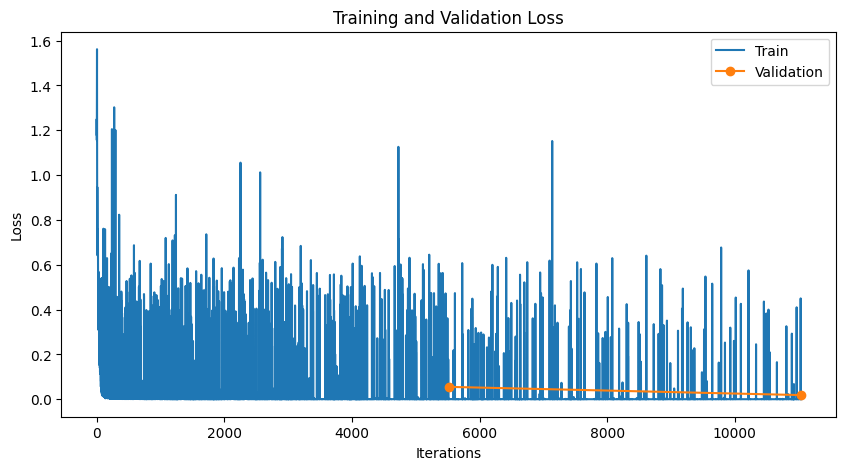

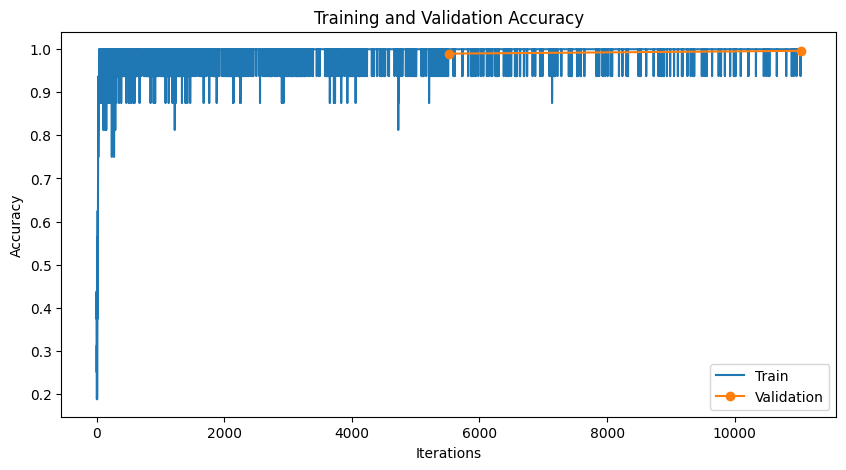

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9962

Evaluating on test set...


Evaluating: 100%|██████████| 1183/1183 [04:31<00:00,  4.36it/s]



Classification Report:
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00     12112
          AI       0.99      1.00      1.00      6814

    accuracy                           1.00     18926
   macro avg       1.00      1.00      1.00     18926
weighted avg       1.00      1.00      1.00     18926

Test accuracy: 0.9965


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification # Import RobertaModel
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import nltk
from nltk.corpus import stopwords
from textstat import flesch_reading_ease
import string
from tqdm import tqdm
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Download NLTK resources at the start
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Constants
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5
MODEL_NAME = 'roberta-base'

# --------------------------
# Feature Extraction
# --------------------------

class LinguisticFeatureExtractor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def extract_features(self, text):
        # Sentence-level features
        sentences = nltk.sent_tokenize(text)
        sentence_count = len(sentences)
        words = nltk.word_tokenize(text)
        word_count = len(words)

        # Calculate features
        features = {}

        # Avg. sentence length
        features['avg_sentence_length'] = word_count / sentence_count if sentence_count > 0 else 0

        # Avg. word length
        char_count = sum(len(word) for word in words)
        features['avg_word_length'] = char_count / word_count if word_count > 0 else 0

        # Stopword ratio
        stopword_count = sum(1 for word in words if word.lower() in self.stop_words)
        features['stopword_ratio'] = stopword_count / word_count if word_count > 0 else 0

        # Punctuation count
        features['punctuation_count'] = sum(1 for char in text if char in string.punctuation)

        # Uppercase word ratio
        uppercase_count = sum(1 for word in words if word.isupper())
        features['uppercase_ratio'] = uppercase_count / word_count if word_count > 0 else 0

        # Readability score
        features['readability_score'] = flesch_reading_ease(text)

        # Type-token ratio
        unique_words = set(words)
        features['type_token_ratio'] = len(unique_words) / word_count if word_count > 0 else 0

        return features

# --------------------------
# Dataset Class
# --------------------------

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len, feature_extractor):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Extract linguistic features
        features = self.feature_extractor.extract_features(text)
        features_tensor = torch.tensor([
            features['avg_sentence_length'],
            features['avg_word_length'],
            features['stopword_ratio'],
            features['punctuation_count'],
            features['uppercase_ratio'],
            features['readability_score'],
            features['type_token_ratio']
        ], dtype=torch.float)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'linguistic_features': features_tensor,
            'label': torch.tensor(label, dtype=torch.long)
        }

# --------------------------
# Hybrid Model Architecture
# --------------------------

class HybridClassifier(nn.Module):
    def __init__(self, n_linguistic_features, n_classes=2):
        super(HybridClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(MODEL_NAME)
        self.linguistic_fc = nn.Linear(n_linguistic_features, 32)
        self.classifier = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size + 32, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, n_classes)
        )

    def forward(self, input_ids, attention_mask, linguistic_features):
        roberta_output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooled_output = roberta_output.pooler_output
        linguistic_output = torch.relu(self.linguistic_fc(linguistic_features))

        combined = torch.cat((pooled_output, linguistic_output), dim=1)
        return self.classifier(combined)

# --------------------------
# Training Functions
# --------------------------

def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        linguistic_features = batch['linguistic_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            linguistic_features=linguistic_features
        )

        loss = nn.CrossEntropyLoss()(outputs, labels)
        losses.append(loss.item())

        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            linguistic_features = batch['linguistic_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                linguistic_features=linguistic_features
            )

            loss = nn.CrossEntropyLoss()(outputs, labels)
            losses.append(loss.item())

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct_predictions.double() / len(data_loader.dataset)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Human', 'AI']))

    return accuracy, np.mean(losses)

# --------------------------
# Main Training Pipeline
# --------------------------

def main():
    # Load datasets
    data_path = '/content/drive/MyDrive/Data/'
    ai_train = pd.read_csv(data_path + "ai_train.csv")
    human_train = pd.read_csv(data_path + "human_train.csv")
    ai_val = pd.read_csv(data_path + "ai_val.csv")
    human_val = pd.read_csv(data_path + "human_val.csv")

    # Create labels (1=AI, 0=Human)
    ai_train['label'] = 1
    human_train['label'] = 0
    ai_val['label'] = 1
    human_val['label'] = 0

    # Combine datasets
    train_df = pd.concat([ai_train, human_train])
    val_df = pd.concat([ai_val, human_val])

    # Initialize components
    tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
    feature_extractor = LinguisticFeatureExtractor()

    # Create datasets
    train_dataset = TextDataset(
        texts=train_df['text_clean'].values,
        labels=train_df['label'].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN,
        feature_extractor=feature_extractor
    )

    val_dataset = TextDataset(
        texts=val_df['text_clean'].values,
        labels=val_df['label'].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN,
        feature_extractor=feature_extractor
    )

    # Create data loaders
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=BATCH_SIZE,
        num_workers=2
    )

    # Initialize model
    model = HybridClassifier(n_linguistic_features=7).to(device)

    # Set up optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Lists to store metrics for plotting
    iters = []
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    iteration = 0

    # Training loop
    best_accuracy = 0
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        # Training
        model.train()
        epoch_train_loss = 0
        epoch_train_correct = 0
        train_samples = 0

        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            linguistic_features = batch['linguistic_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                linguistic_features=linguistic_features
            )

            loss = nn.CrossEntropyLoss()(outputs, labels)
            _, preds = torch.max(outputs, dim=1)
            epoch_train_correct += torch.sum(preds == labels).item()
            epoch_train_loss += loss.item() * input_ids.size(0)
            train_samples += input_ids.size(0)

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            # Store metrics per iteration
            iters.append(iteration)
            train_losses.append(loss.item())
            train_accs.append((torch.sum(preds == labels).double() / input_ids.size(0)).item())
            iteration += 1

        # Compute epoch-level training metrics
        epoch_train_loss /= train_samples
        epoch_train_acc = epoch_train_correct / train_samples
        print(f'Train loss: {epoch_train_loss:.4f}, accuracy: {epoch_train_acc:.4f}')

        # Validation
        val_acc, val_loss = eval_model(model, val_loader, device)
        print(f'Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}')
        val_accs.append(val_acc.item())
        val_losses.append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model.bin')
            best_accuracy = val_acc

    # Plotting
    # Adjust x-axis for validation metrics to align with the end of each epoch
    epoch_iters = [i for i in range(len(train_loader) - 1, len(iters), len(train_loader))] + ([len(iters) - 1] if len(iters) % len(train_loader) != 0 else [])

    plt.figure(figsize=(10, 5))
    plt.title("Training and Validation Loss")
    plt.plot(iters, train_losses, label="Train", color="#1f77b4")
    plt.plot(epoch_iters, val_losses, label="Validation", color="#ff7f0e", marker='o')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.title("Training and Validation Accuracy")
    plt.plot(iters, train_accs, label="Train", color="#1f77b4")
    plt.plot(epoch_iters, val_accs, label="Validation", color="#ff7f0e", marker='o')
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print(f"Final Training Accuracy: {train_accs[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")

    # Load best model and evaluate on test set
    print("\nEvaluating on test set...")
    model.load_state_dict(torch.load('best_model.bin'))

    # Load test data
    ai_test = pd.read_csv(data_path + "ai_test.csv")
    human_test = pd.read_csv(data_path + "human_test.csv")
    ai_test['label'] = 1
    human_test['label'] = 0
    test_df = pd.concat([ai_test, human_test])

    test_dataset = TextDataset(
        texts=test_df['text_clean'].values,
        labels=test_df['label'].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN,
        feature_extractor=feature_extractor
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=2
    )

    test_acc, test_loss = eval_model(model, test_loader, device)
    print(f'Test accuracy: {test_acc:.4f}')

if __name__ == "__main__":
    main()